In [1]:
from ReadFile import Read 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from CenterofMass import CenterOfMass
import astropy.units as u
from astropy.constants import G

In [123]:
class  MassProfile:
    #class for calculating the mass distribution of each galaxy at SnapNumber 0
    #used to determine the galaxy's rotation curve.
    def __init__(self, galaxy, Snap):
        ''' initializing the class to calculate the mass distribution of a galaxy.

            
            PARAMETERS
            ----------
            galaxy : `str`
                Galaxy name e.g. 'M31'
            snap : `int; 0, 1, 2, ...`
                Snapshot number
        '''
        #add a string of the filenumber to the value “000”
        ilbl = "000"+ str(Snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename= "/Users/swapnaneeldey/Desktop/ASTR400Bfiles/%s_"%(galaxy) + ilbl + '.txt'
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename) 
        # store the mass, positions, velocities of the particle
        # the following only gives the example of storing the mass
        self.m = self.data['m']
        # write your own code to complete this for positions and velocities
        self.x = self.data['x']*u.kpc
        self.y = self.data["y"]*u.kpc
        self.z = self.data["z"]*u.kpc
        # storing the name of the galaxy as a global variable
        self.gname = galaxy

    def MassEnclosed(self, ptype, radii):
        """compute the mass enclosed within a given
           radius of the COM position for a specified galaxy
         and a specified component of that galaxy.
         
         Parameters:
         -----------
         ptype : `str`
             Particle type, e.g. 'disk', 'halo', 'bulge'
         radii : `array` in kpc
             Array of radii at which the mass is computed

         Returns:
         enclosed_mass : `array`
             Array of enclosed mass at each radius"""

        # find the center of mass position of the galaxy using disk particles
        galaxy_COM = CenterOfMass(self.filename, 2)
        # store the center of mass position
        galaxy_COM_P = galaxy_COM.COM_P(0.1)
        # store the mass of each particle within the radii
        particle_mass_enclosed_array = np.zeros(len(radii))
        # identify particles that are enclodes within the radii
        index = np.where(self.data["type"] == ptype)
        all_radii = np.sqrt((self.x[index]-galaxy_COM_P[0])**2+(self.y[index]-galaxy_COM_P[1])**2+(self.z[index]-galaxy_COM_P[2])**2)
        # loop over the radii
        for i in range(len(radii)):
            # get the mass of those particles
            particle_mass_enclosed_array[i] = np.sum(self.m[index][np.where(all_radii < radii[i]*u.kpc)]) * 1e10
        return particle_mass_enclosed_array * u.M_sun
    
    def MassEnclosedTotal(self, radii):
        """Function to calculate the total mass enclosed (bludge + disk + halo)
          within a given radius of the COM position
          
          Parameters:
          -----------
          radii : `array`
              Array of radii at which the mass is computed
        
          Returns:
          -----------
          total_enclosed_mass : `array`
              Array of enclosed mass at each radius"""
        #creating a mass array
        mass_array = np.zeros(len(radii))*u.M_sun
        # calling MassEnclosed for each type of particle
        for i in [1,2,3]:
            if self.gname != "M33":
                mass_array += self.MassEnclosed(i, radii)
            else:
                if i != 3:
                    mass_array += self.MassEnclosed(i, radii)
        return mass_array

    def HernquistMass(self, r, a, Mhalo):
        """Function to calculate the enclosed mass using Hernquist profile
        
        Parameters:
        -----------
        r : `array`
            Array of radii at which the mass is computed
        a : `float`
            Scale factor   
        Mhalo : `float`
            Halo mass in 1e12 Msun
            
        Returns:
        -----------
        M : `array`
            returns the enclosed mass"""

        b = Mhalo*1e12*u.Msun # constatnts, correction units
        r = r*u.kpc # correction units
        c = r**2/(a*u.kpc + r)**2

        mass = b * c # herniquist profile  

        return mass
    
    def CircularVelocity(self, ptype, radii):
        """Function to calculate the circular velocity for a given particle type
            at specified radii.
        
        Parameters:
        -----------
        ptype : `str`
            Particle type, e.g. 'disk', 'halo', 'bulge'
        radii : `array`
            Array of radii at which the mass is computed
            
        returns:
        -----------
        V_circ : `array` units = km/s rounded to 2 decimal points
            Array of circular velocities at each radius"""
        
        G_const = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        # calculate the circular speed of the particle type
        mass_enc = self.MassEnclosed(ptype, radii)
        # calculate the circular speed using v = sqrt(GM/r)
        V_circ = np.sqrt(G_const*mass_enc/(radii*u.kpc)).to(u.km/u.s)
        return np.around(V_circ.value, 2)*u.km/u.s
    
    def CirculatVelocityTotal(self, radii):
        """Function to calculate the total circular velocity (bludge + disk + halo)
            at specified radii.
        
        Parameters:
        -----------
        radii : `array`
            Array of radii at which the mass is computed
            
        returns:
        -----------
        V_circ : `array` units = km/s rounded to 2 decimal points
            Array of circular velocities at each radius"""
        G_const = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        # calculate the circular speed of all particle type
        mass_enc = self.MassEnclosedTotal(radii)
        # calculate the circular speed using v = sqrt(GM/r)
        V_circ = np.sqrt(G_const*mass_enc/(radii*u.kpc)).to(u.km/u.s)
        return np.around(V_circ.value, 2)*u.km/u.s
    
    def HernquistVCirc(self, r, a, Mhalo):
        """Function to calculate the circular velocity using Hernquist profile
        
        Parameters:
        -----------
        r : `array`
            Array of radii at which the mass is computed
        a : `float`
            Scale factor   
        Mhalo : `float`
            Halo mass in 1e12 Msun
            
        Returns:
        -----------
        V : `array` in km/s rounded to 2 decimal points
            returns the circular velocity"""
        
        # constants
        G_const = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        # calculate the circular speed of all particle type
        mass_enc = self.HernquistMass(r, a, Mhalo)
        # calculate the circular speed using v = sqrt(GM/r)
        V_circ_h = np.sqrt(G_const*mass_enc/(r*u.kpc)).to(u.km/u.s)
        V_circ_array = V_circ_h.value  # Extract numerical values

        # Round to 2 decimal places while keeping it as float
        rounded_V = np.around(V_circ_array, 2)

        return rounded_V * u.km/u.s

In [ ]:
# Creating an object for the MW
#  
MW = MassProfile("MW", 0)


In [136]:
# defining an array of radii
r = np.arange(0.1, 30.5, 0.5)


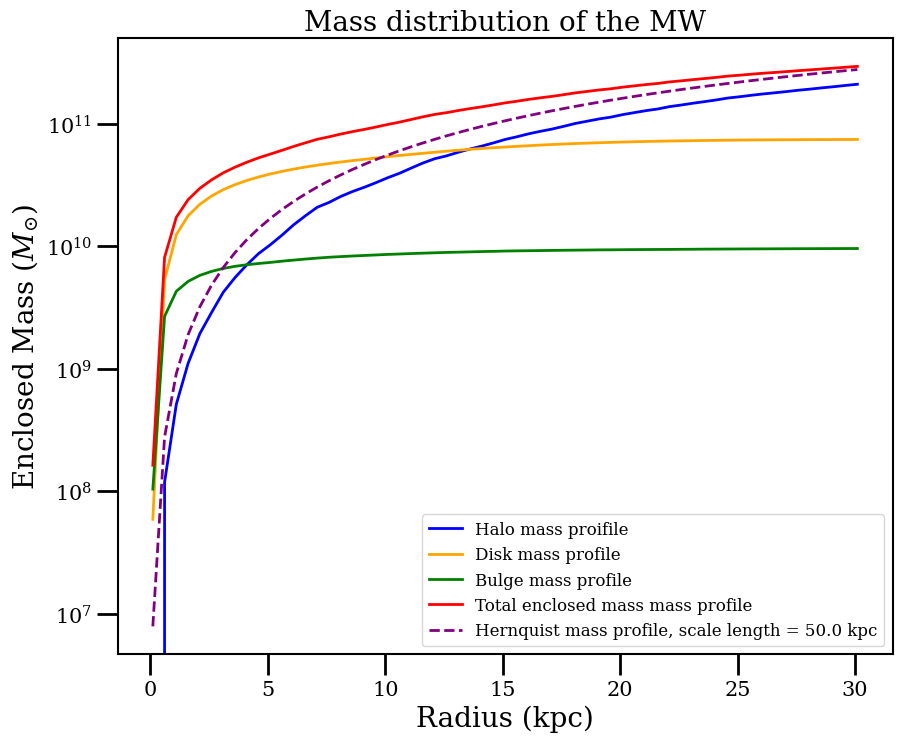

In [ ]:
# formatting the plot
plt.rcParams.update({
    "font.family": "DejaVu Serif",   # specify font family here
    "font.serif": ["cm"],
    "mathtext.fontset" : "dejavuserif" ,
    "font.size":17,
    "axes.titlesize" : 20,
    "axes.labelsize" : 20,
    "axes.linewidth" : 1.5,
    "lines.linewidth" : 2.0,
    "xtick.labelsize" :15,
    "ytick.labelsize" : 15,
    "xtick.major.size" : 15,
    "xtick.minor.size" : 0,
    "ytick.major.size" : 15,
    "ytick.minor.size" : 0,
    "xtick.major.width" : 2,
    "xtick.minor.width" : 2,
    "ytick.major.width" : 2,
    "ytick.minor.width" : 2})  
plt.rcParams["legend.frameon"] = True
fig= plt.figure(figsize=(10,8))
# defining halo mass and scale length of MW for herquist profile
M_halo = 1.975
a = 50
# plotting the enclosed mass of each component
plt.semilogy(r, MW.MassEnclosed(1, r), color = "blue", label = "Halo mass proifile")
plt.semilogy(r, MW.MassEnclosed(2, r), color = "orange", label = "Disk mass profile")
plt.semilogy(r, MW.MassEnclosed(3, r), color = "green", label = "Bulge mass profile")
# plotting the total enclosed mass
plt.semilogy(r, MW.MassEnclosedTotal(r), color = "red", label = "Total enclosed mass mass profile")
# plotting the hernquist profile
plt.semilogy(r, MW.HernquistMass(r, a, M_halo), color = "purple", ls = "--", label = f"Hernquist mass profile, scale length = {a*u.kpc}")
plt.title("Mass distribution of the MW")
plt.xlabel("Radius (kpc)")
plt.ylabel("Enclosed Mass ($M_{\odot}$)")
plt.legend(loc = "lower right", fontsize = 12)

In [ ]:
# Creating an object for the M31
M31 = MassProfile("M31", 0)


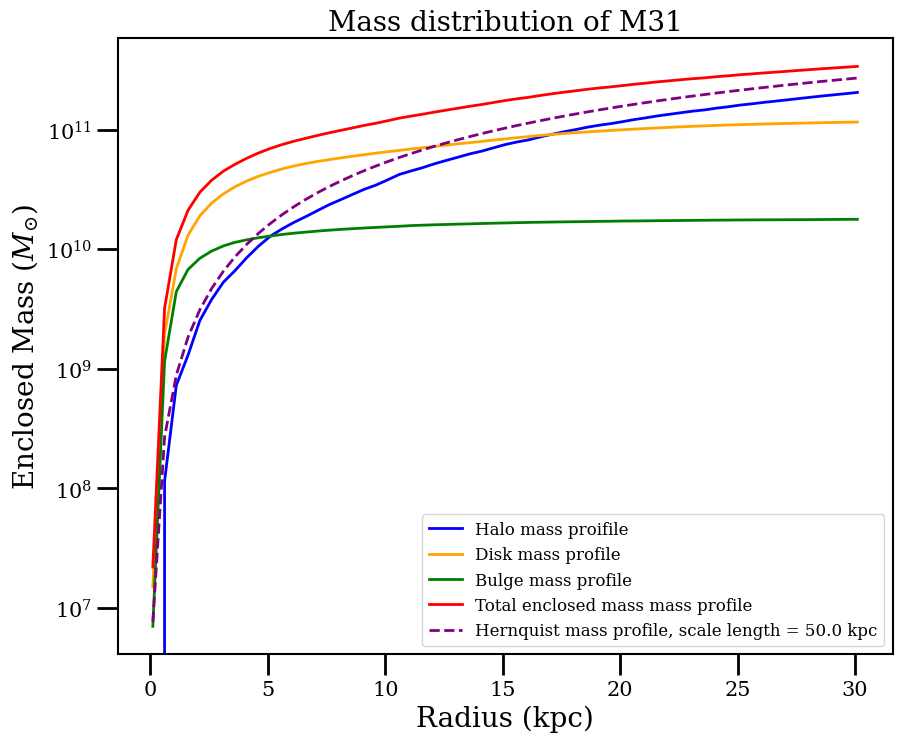

In [ ]:

fig= plt.figure(figsize=(10,8))
# defining halo mass and scale length of M31 for herquist profile
M_halo = 1.921
a = 50
# plotting the enclosed mass of each component
plt.semilogy(r, M31.MassEnclosed(1, r), color = "blue", label = "Halo mass proifile")
plt.semilogy(r, M31.MassEnclosed(2, r), color = "orange", label = "Disk mass profile")
plt.semilogy(r, M31.MassEnclosed(3, r), color = "green", label = "Bulge mass profile")
# plotting the total enclosed mass
plt.semilogy(r, M31.MassEnclosedTotal(r), color = "red", label = "Total enclosed mass mass profile")
# plotting the hernquist profile
plt.semilogy(r, M31.HernquistMass(r, a, M_halo), color = "purple", ls = "--", label = f"Hernquist mass profile, scale length = {a*u.kpc}")
plt.title("Mass distribution of M31")
plt.xlabel("Radius (kpc)")
plt.ylabel("Enclosed Mass ($M_{\odot}$)")
plt.legend(loc = "lower right", fontsize = 12)

In [ ]:
# Creating an object for the M33
M33 = MassProfile("M33", 0)


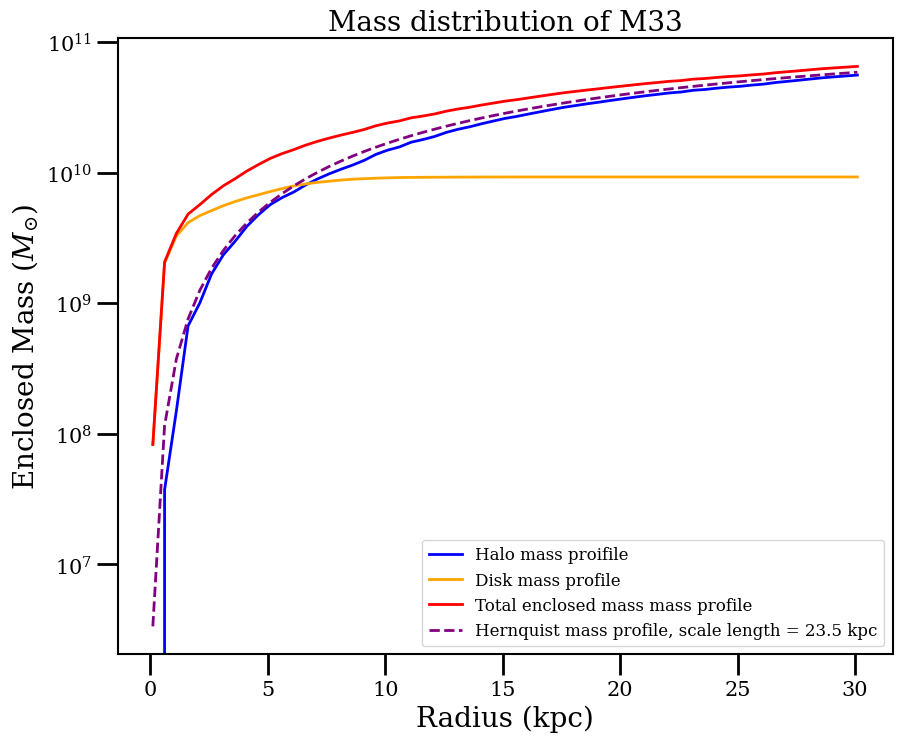

In [ ]:
fig= plt.figure(figsize=(10,8))
# defining halo mass and scale length of M33 for herquist profile
M_halo = 0.187
a = 23.5
# plotting the enclosed mass of each component
plt.semilogy(r, M33.MassEnclosed(1, r), color = "blue", label = "Halo mass proifile")
plt.semilogy(r, M33.MassEnclosed(2, r), color = "orange", label = "Disk mass profile")
#plt.semilogy(r, M33.MassEnclosed(3, r), color = "green", label = "Bulge mass profile")
# plotting the total enclosed mass
plt.semilogy(r, M33.MassEnclosedTotal(r), color = "red", label = "Total enclosed mass mass profile")
# plotting the hernquist profile
plt.semilogy(r, M33.HernquistMass(r, a, M_halo), color = "purple", ls = "--", label = f"Hernquist mass profile, scale length = {a*u.kpc}")
plt.title("Mass distribution of M33")
plt.xlabel("Radius (kpc)")
plt.ylabel("Enclosed Mass ($M_{\odot}$)")
plt.legend(loc = "lower right", fontsize = 12)

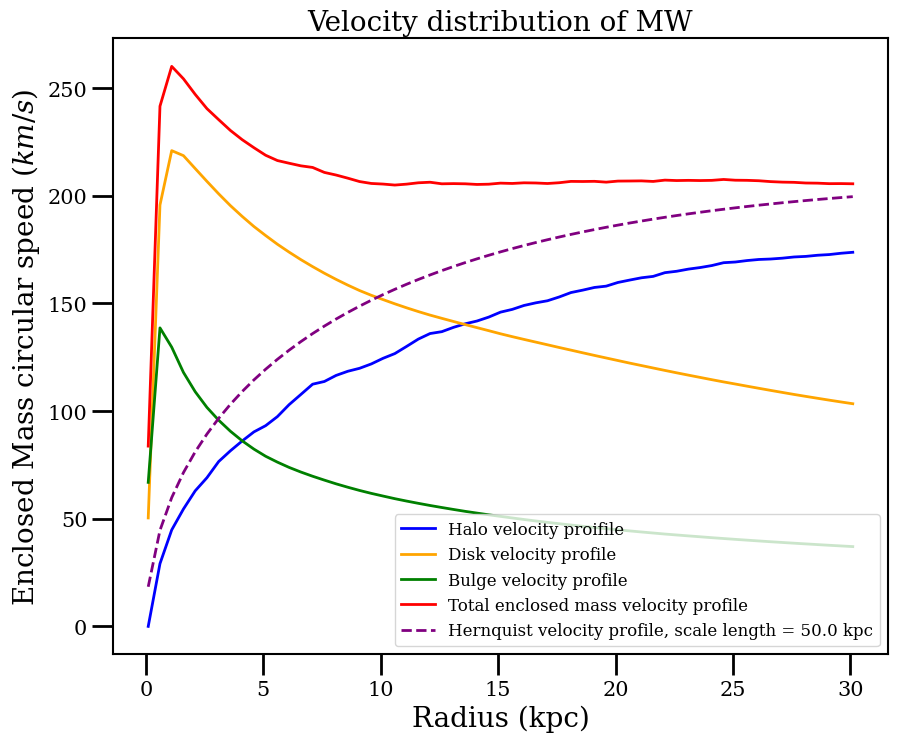

In [ ]:
fig= plt.figure(figsize=(10,8))
# defining halo mass and scale length of MW for herquist profile
M_halo = 1.975
a = 50
# plotting the circular velocity of each component
plt.plot(r, MW.CircularVelocity(1, r), color = "blue", label = "Halo velocity proifile")
plt.plot(r, MW.CircularVelocity(2, r), color = "orange", label = "Disk velocity profile")
plt.plot(r, MW.CircularVelocity(3, r), color = "green", label = "Bulge velocity profile")
# plotting the total circular velocity
plt.plot(r, MW.CirculatVelocityTotal(r), color = "red", label = "Total enclosed mass velocity profile")
# plotting the hernquist profile
plt.plot(r, MW.HernquistVCirc(r, a, M_halo), color = "purple", ls = "--", label = f"Hernquist velocity profile, scale length = {a*u.kpc}")
plt.title("Velocity distribution of MW")
plt.xlabel("Radius (kpc)")
plt.ylabel("Enclosed Mass circular speed ($km/s$)")
plt.legend(loc = "lower right", fontsize = 12)

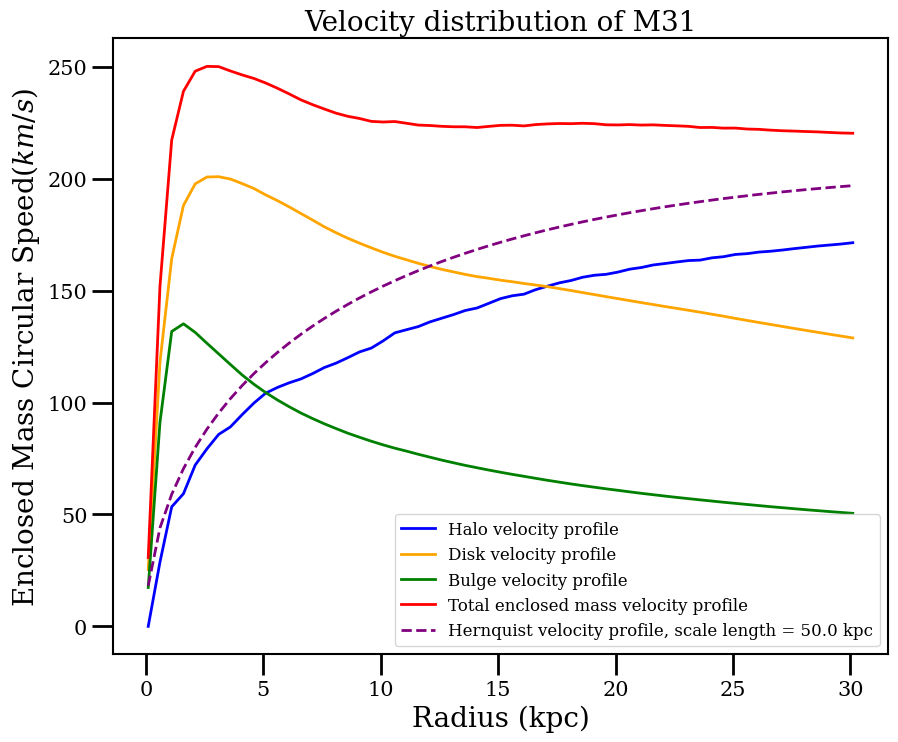

In [ ]:
fig= plt.figure(figsize=(10,8))
M_halo = 1.921
a = 50
# plotting the circular velocity of each component
plt.plot(r, M31.CircularVelocity(1, r), color = "blue", label = "Halo velocity profile")
plt.plot(r, M31.CircularVelocity(2, r), color = "orange", label = "Disk velocity profile")
plt.plot(r, M31.CircularVelocity(3, r), color = "green", label = "Bulge velocity profile")
# plotting the total circular velocity
plt.plot(r, M31.CirculatVelocityTotal(r), color = "red", label = "Total enclosed mass velocity profile")
# plotting the hernquist profile
plt.plot(r, M31.HernquistVCirc(r, a, M_halo), color = "purple", ls = "--", label = f"Hernquist velocity profile, scale length = {a*u.kpc}")
plt.title("Velocity distribution of M31")
plt.xlabel("Radius (kpc)")
plt.ylabel("Enclosed Mass Circular Speed($km/s$)")
plt.legend(loc = "lower right", fontsize = 12)

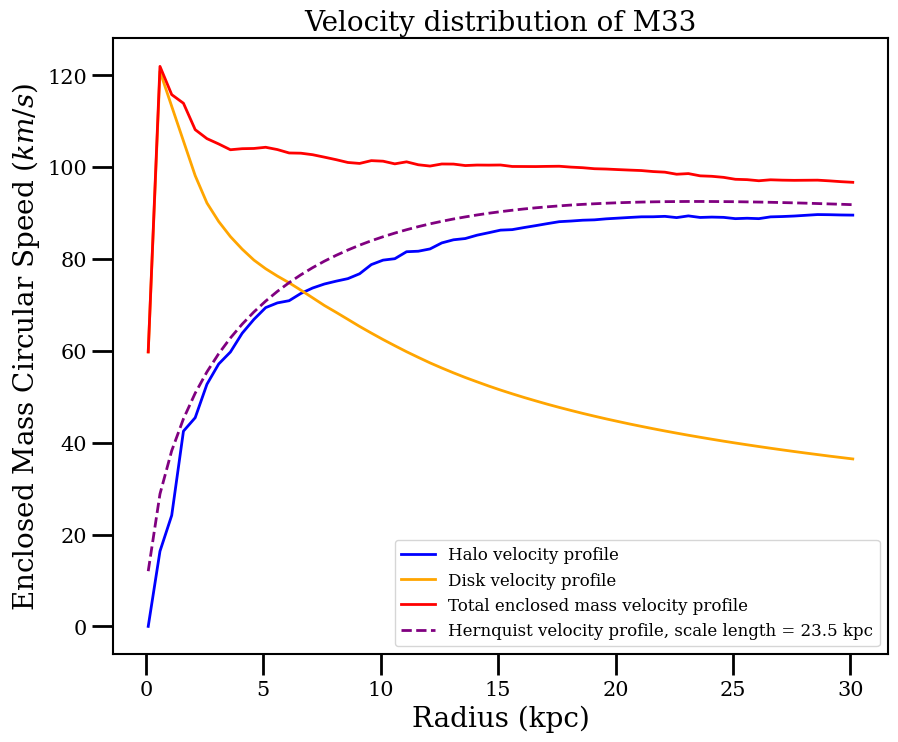

In [ ]:
fig= plt.figure(figsize=(10,8))
M_halo = 0.187
a = 23.5
# plotting the circular velocity of each component
plt.plot(r, M33.CircularVelocity(1, r), color = "blue", label = "Halo velocity profile")
plt.plot(r, M33.CircularVelocity(2, r), color = "orange", label = "Disk velocity profile")
#plt.semilogy(r, M33.CircularVelocity(3, r), color = "green", label = "Bulge velocity profile")
# plotting the total circular velocity
plt.plot(r, M33.CirculatVelocityTotal(r), color = "red", label = "Total enclosed mass velocity profile")
# plotting the hernquist profile
plt.plot(r, M33.HernquistVCirc(r, a, M_halo), color = "purple", ls = "--", label = f"Hernquist velocity profile, scale length = {a*u.kpc}")
plt.title("Velocity distribution of M33")
plt.xlabel("Radius (kpc)")
plt.ylabel("Enclosed Mass Circular Speed ($km/s$)")
plt.legend(loc = "lower right", fontsize = 12)